In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

/home/lena/Promotion/neurolib/GUI/current/gui/data/00171
00171


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]
elif case[3] == '3':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '4':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '5':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '6':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '7':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '8':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
    
if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
start_index = 1
#i_range = range(start_index, limit,i_stepsize)
#i_range_0 = range(start_index, limit,i_stepsize)
#i_range_1 = range(start_index, limit,i_stepsize)

i_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
           27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
           95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
i_range_0 = i_range
i_range_1 = i_range

data.set_parameters(aln)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  1 0.4250000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  6 0.4250000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  19 0.4250000000000001 0.4750000000000002

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  117490.19066384812
Gradient descend method:  None
RUN  0 , total integrated cost =  117490.19066384812
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  195397.53146152175
Gradient descend method:  None
RUN  0 , total integrated cost =  195397.53146152175
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  110250.59580314568
Gradient descend method:  None
RUN  0 , total integrated cost =  110250.59580314568
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3 0.4250000000000001 0.37500000000000

RUN  0 , total integrated cost =  517243.1942837929
Gradient descend method:  None
RUN  0 , total integrated cost =  517243.1942837929
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  158812.17434988057
Gradient descend method:  None
RUN  0 , total integrated cost =  158812.17434988057
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  31 0.4500000000000001 0.5250000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  243636.6192478032
Gradient descend method:  None
RUN  0 , total integrated cost =  243636.6192478032
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  329798.21759

RUN  0 , total integrated cost =  662654.2085521322
Gradient descend method:  None
RUN  0 , total integrated cost =  662654.2085521322
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [14]:
factor_iteration = 20.
aln.params.duration = dur

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    ##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if conv_init[i] == [True, True]:
    
        with open(read_file,'rb') as f:
            load_array = pickle.load(f)

        bestControl_read = load_array[0]

        bestControl_init[i] = np.zeros(( 1, 6, n_dur + n_pre + n_post -2 ))
        bestControl_init[i][:,:,n_pre-1+1000:n_pre-1+2000] = bestControl_read[i][:,:,n_pre-1:n_pre-1+1000].copy()
        weights_init = load_array[7]
        
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]   
        cost.setParams(weights_init[i][0], weights_init[i][1], weights_init[i][2])

        
        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 0, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        continue
    
    
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 5828.257030205453
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5838.268321847803
Gradient descend method:  None
RUN  0 , total integrated cost =  5838.268321847803
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 17152.5709866041
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9676.682394490988
Gradient descend method:  None
RUN  0 , total integrated cost =  9676.682394490988
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 3360.4768393109575
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5441.062025204899
Gradient descend method:  None
RUN  0 , total integrated cost =  5441.062025204899
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3

RUN  0 , total integrated cost =  11970.146897801333
Gradient descend method:  None
RUN  0 , total integrated cost =  11970.146897801333
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 3146.444995923379
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16164.094509101958
Gradient descend method:  None
RUN  0 , total integrated cost =  16164.094509101958
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  39 0.5000000000000002 0.5500000000000003
set cost params:  1.0 0.0 4705.692616735061
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20590.349698038954
Gradient descend method:  None
RUN  0 , total integrated cost =  20590.349698038954
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  40 0.5250000000000001 0.5500000000000003
set cost params:  1.0 0.0 7195.963758852237
interpolate adjoint :  True True True


--------- 1


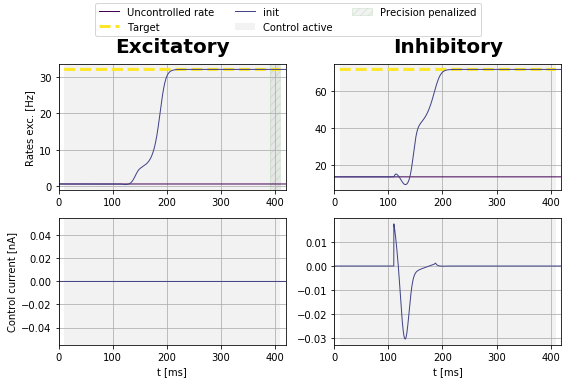

--------- 3


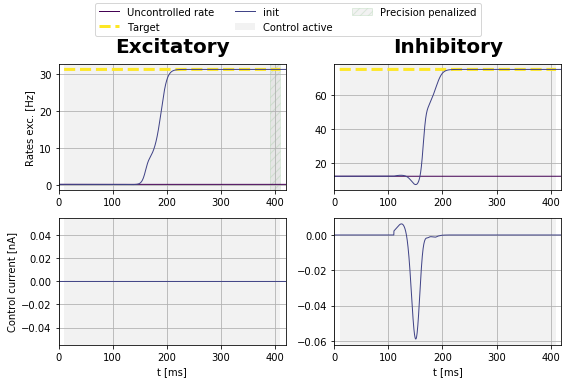

--------- 5


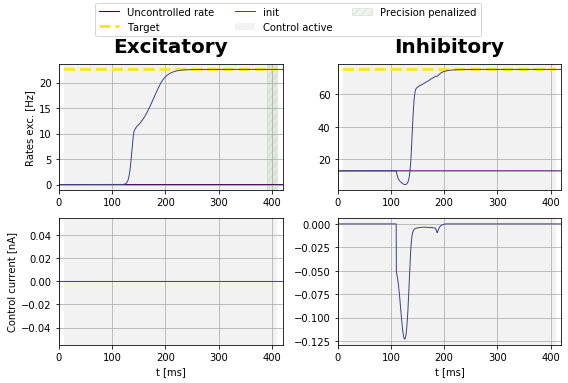

--------- 7


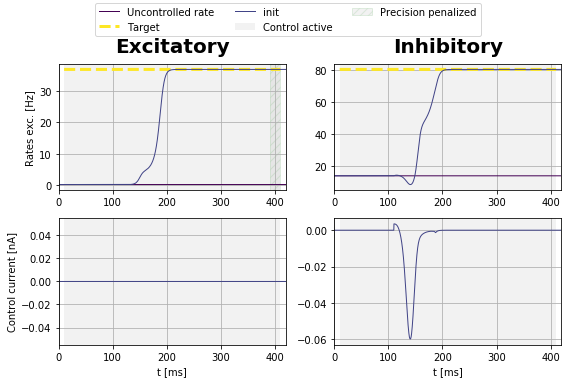

--------- 9


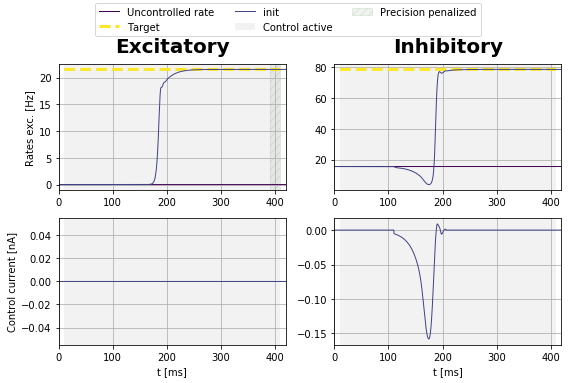

--------- 11


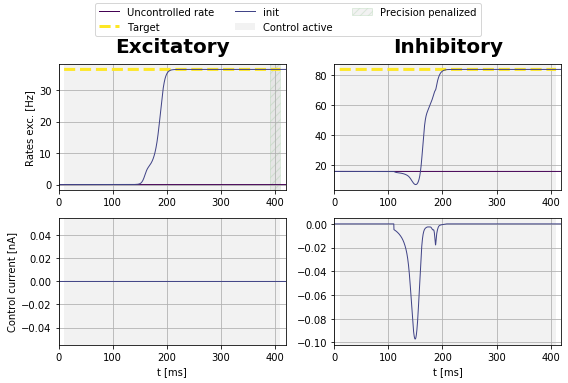

--------- 13


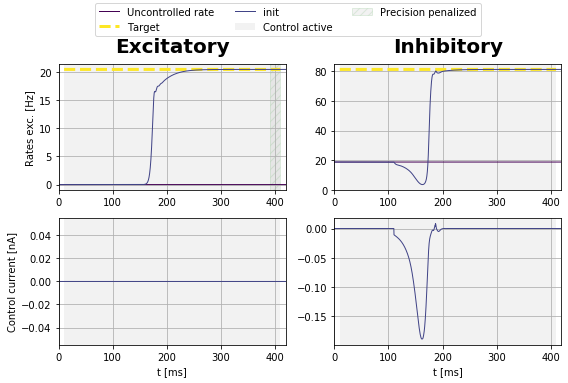

--------- 15


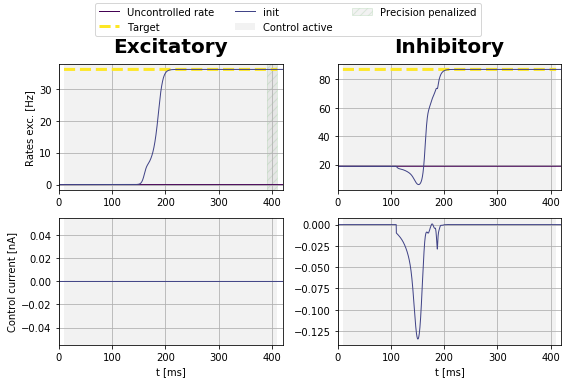

--------- 17


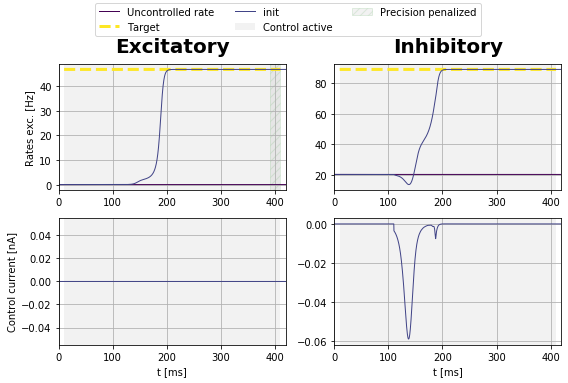

--------- 19


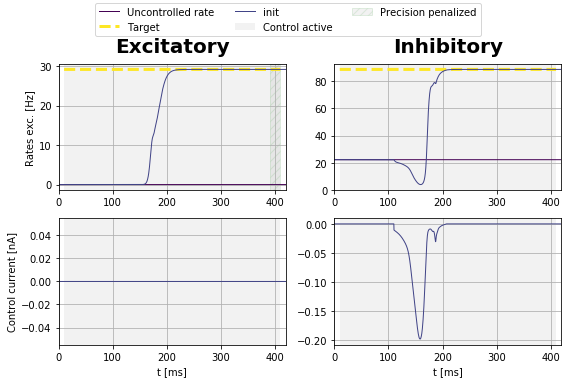

--------- 21


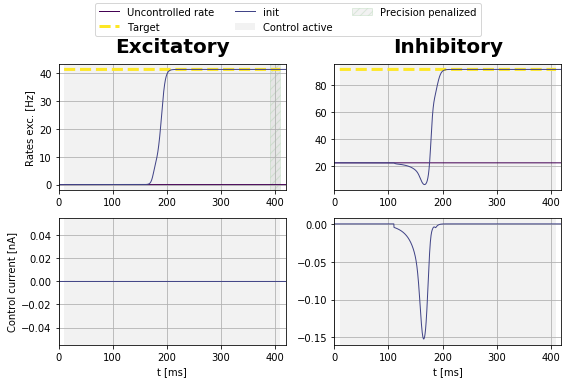

--------- 23


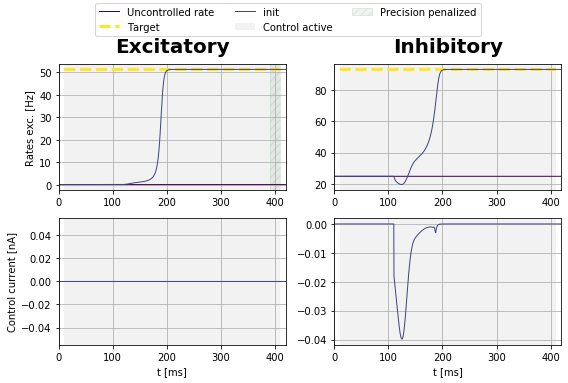

--------- 25


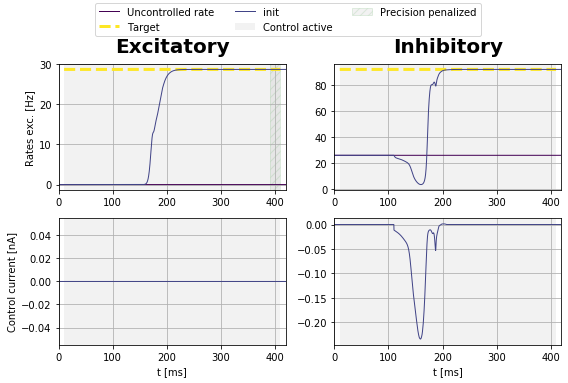

--------- 27


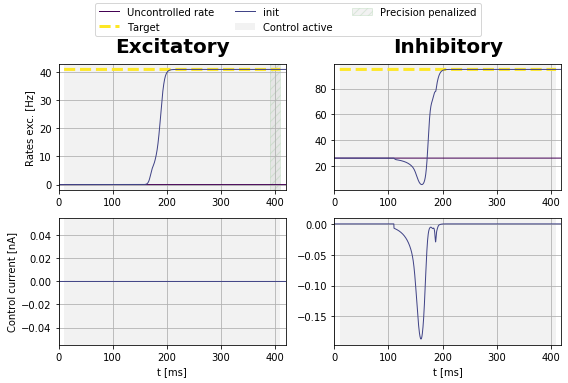

--------- 29


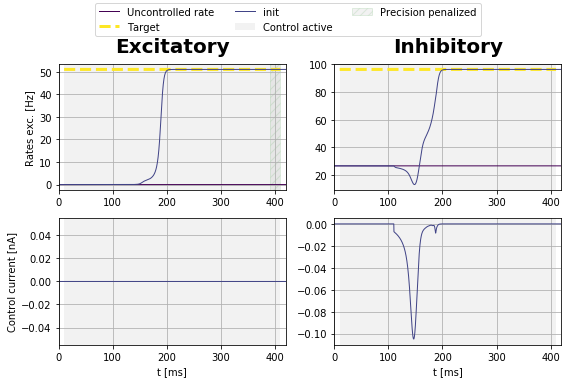

--------- 31


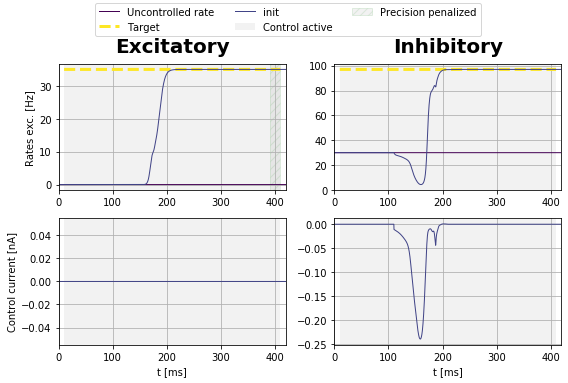

--------- 33


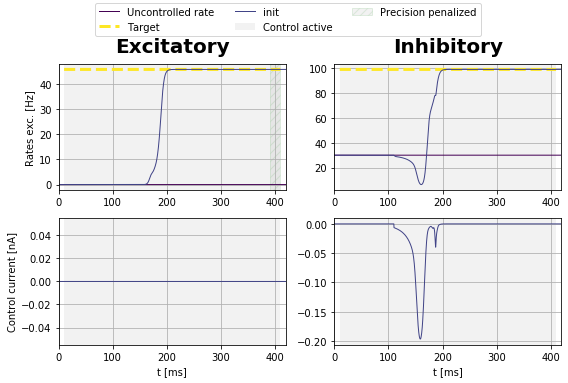

--------- 35


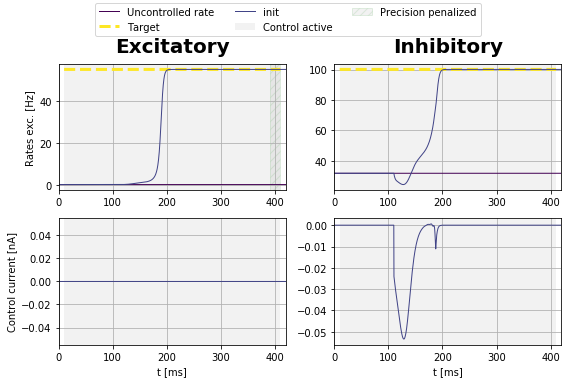

--------- 37


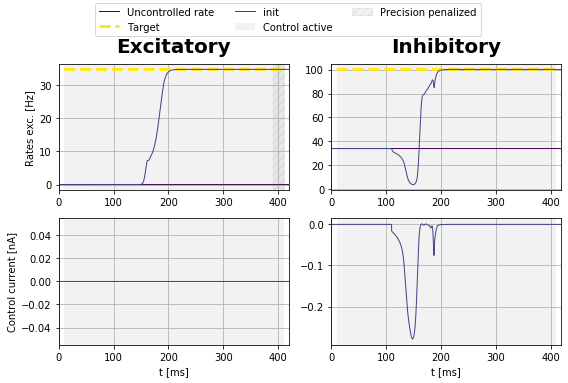

--------- 39


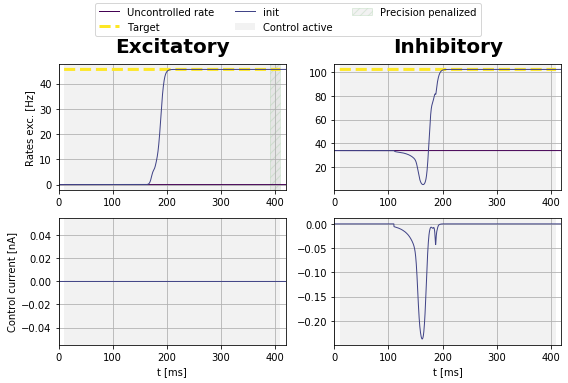

In [15]:
#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [16]:
found_solution = []
no_solution = []
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])    


    if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
        np.mean(bestState_init[i][0,1,-300:]) - target[i][0,1,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amax(
        bestState_init[i][0,0,:]) < target[i][0,0,-1] + 5. and np.amax(
        bestState_init[i][0,1,:]) < target[i][0,1,-1] + 5.:
        # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
        #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
        if i not in found_solution:
            print("found solution for ", i)
            found_solution.append(i)
        if i in no_solution:
            no_solution.pop(no_solution.index(i))
        

-------  1 0.4250000000000001 0.3500000000000001
found solution for  1
-------  3 0.4250000000000001 0.3750000000000001
found solution for  3
-------  5 0.4000000000000001 0.40000000000000013
found solution for  5
-------  7 0.4500000000000001 0.40000000000000013
found solution for  7
-------  9 0.4000000000000001 0.42500000000000016
found solution for  9
-------  11 0.4500000000000001 0.42500000000000016
found solution for  11
-------  13 0.4000000000000001 0.4500000000000002
found solution for  13
-------  15 0.4500000000000001 0.4500000000000002
found solution for  15
-------  17 0.5000000000000002 0.4500000000000002
found solution for  17
-------  19 0.4250000000000001 0.4750000000000002
found solution for  19
-------  21 0.47500000000000014 0.4750000000000002
found solution for  21
-------  23 0.5250000000000001 0.4750000000000002
found solution for  23
-------  25 0.4250000000000001 0.5000000000000002
found solution for  25
-------  27 0.47500000000000014 0.5000000000000002
found

In [17]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [18]:
factor_iteration = 6
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 6:
        break
        
    print(conv_0[start_index:limit:i_stepsize])
    full_converge = True
    
    for conv in conv_0[start_index:limit:i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  21709.411096479835
set cost params:  1.0 0.0 21709.411096479835
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.819742136056
Gradient descend method:  None
RUN  1 , total integrated cost =  9815.819740475914
RUN  2 , total integrated cost =  9815.819739882141
RUN  3 , total integrated cost =  9815.81973984917
RUN  4 , total integrated cost =  9815.819739779738
RUN  5 , total integrated cost =  9815.81973484389
RUN  6 , total integrated cost =  9815.819731899628
RUN  7 , total integrated cost =  9815.819731868347
RUN  8 , total integrated cost =  9815.819731746013
RUN

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  9815.777082298895
RUN  3000 , total integrated cost =  9815.777082298895
Improved over  3000  iterations in  704.4853594  seconds by  0.0004346028990198647  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489939890927 -56.6548994202629
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  9920.067703601695
set cost params:  1.0 0.0 9920.067703601695
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.590616753554
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.590616753554
Control only changes marginally.
RUN  1 , total integrated cost =  9704.590616753554
Improved over  1  iterations in  0.5828239999999596  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65188888269914 -56.651888910128406
no convergence
-------  5 0.4000000000000001 0.40000000000000013
weight =  2216.4842710635635
set cost params:  1.0 0.0 2216.4842710635635
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.991146808961
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5094.991146808961
Control only changes marginally.
RUN  1 , total integrated cost =  5094.991146808961
Improved over  1  iterations in  0.5239362999999457  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62446452985816 -56.62446454405417
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  13089.911663891857
set cost params:  1.0 0.0 13089.911663891857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13556.169489299973
Gradient descend method:  None
RUN  1 , total integrated cost =  13556.169489299973
Control only changes marginally.
RUN  1 , total integrated cost =  13556.169489299973
Improved over  1  iterations in  0.584174599999983  seconds by  0.0  percent.
no convergence
-------  9 0.4000000000000001 0.42500000000000016
weight =  1479.4709049999353
set cost params:  1.0 0.0 1479.4709049999353
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4639.14027

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4639.1402777672265
Control only changes marginally.
RUN  1 , total integrated cost =  4639.1402777672265
Improved over  1  iterations in  0.5654625000000806  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62496046384282 -56.62495969344398
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  7660.314908139747
set cost params:  1.0 0.0 7660.314908139747
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.69828384162
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.69828384162
Control only changes marginally.
RUN  1 , total integrated cost =  13309.69828384162
Improved over  1  iterations in  0.5457146999999622  seconds by  0.0  percent.
no convergence
-------  13 0.4000000000000001 0.4500000000000002
weight =  1043.90419380651
set cost params:  1.0 0.0 1043.90419380651
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.24940074659


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  4173.249400746589
Control only changes marginally.
RUN  2 , total integrated cost =  4173.249400746589
Improved over  2  iterations in  0.9679796000000351  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772660507793 -56.6277250446544
no convergence
-------  15 0.4500000000000001 0.4500000000000002
weight =  5154.109386230694
set cost params:  1.0 0.0 5154.109386230694
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13015.549364224264
Gradient descend method:  None
RUN  1 , total integrated cost =  13015.549364224264
Control only changes marginally.
RUN  1 , total integrated cost =  13015.549364224264
Improved over  1  iterations in  0.5254128999999921  seconds by  0.0  percent.
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  21158.957903846618
set cost params:  1.0 0.0 21158.957903846618
interpolate adjoint :  True True True
RUN  0 , total integrated c

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8499.459253137808
Control only changes marginally.
RUN  3 , total integrated cost =  8499.459253137808
Improved over  3  iterations in  1.4891798999999537  seconds by  1.6024017668314627e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.6418733752788 -56.64187340897076
no convergence
-------  21 0.47500000000000014 0.4750000000000002
weight =  6544.237193356709
set cost params:  1.0 0.0 6544.237193356709
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.27900049274
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.27900023622
RUN  2 , total integrated cost =  17066.279000234736
RUN  3 , total integrated cost =  17066.279000234714
RUN  4 , total integrated cost =  17066.279000234706
RUN  5 , total integrated cost =  17066.279000234706
Control only changes marginally.
RUN  5 , total integrated cost =  17066.279000234706
Improved over  5  iterations in  2.472286999999824  seconds by  1.51196388

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030082242425
RUN  3000 , total integrated cost =  8227.030082242425
Improved over  3000  iterations in  821.3008711000002  seconds by  1.828395650704806e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.63980006441218 -56.63980010698276
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4680.287247427543
set cost params:  1.0 0.0 4680.287247427543
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.13923656631
Gradient descend method:  None
RUN  1 , total integrated cost =  15918.300614918115
RUN  2 , total integrated cost =  15901.327229504248
RUN  3 , total integrated cost =  15900.51120135935
RUN  4 , total integrated cost =  15900.499725968246
RUN  5 , total integrated cost =  15900.49952741865
RUN  6 , total integrated cost =  15900.499525582865
RUN  7 , total integrated cost =  15900.499525531994
RUN  8 , total integrated cost =  15900.499519798388
RUN  9 , total integrated c

RUN  13 , total integrated cost =  11832.712622092056
RUN  14 , total integrated cost =  11832.712615760096
RUN  15 , total integrated cost =  11832.712606341083
RUN  16 , total integrated cost =  11832.712605905324
RUN  17 , total integrated cost =  11832.712605262714
RUN  18 , total integrated cost =  11832.712605035127
RUN  19 , total integrated cost =  11832.712604459539
RUN  20 , total integrated cost =  11832.712604103383
RUN  30 , total integrated cost =  11832.712577138072
RUN  40 , total integrated cost =  11832.712537748812
RUN  50 , total integrated cost =  11832.712498861425
RUN  60 , total integrated cost =  11832.712467694508
RUN  70 , total integrated cost =  11808.632468887183
RUN  80 , total integrated cost =  11808.632381898227
RUN  90 , total integrated cost =  11808.632362092336
RUN  100 , total integrated cost =  11773.044882754291
Control only changes marginally.
RUN  102 , total integrated cost =  11773.044882754282
Improved over  102  iterations in  28.789467000

RUN  1 , total integrated cost =  19625.45205258945
RUN  2 , total integrated cost =  19579.49758931993
RUN  3 , total integrated cost =  19577.808086993835
RUN  4 , total integrated cost =  19577.800169630715
RUN  5 , total integrated cost =  19577.800148773185
RUN  6 , total integrated cost =  19577.800146670354
RUN  7 , total integrated cost =  19577.800144564957
RUN  8 , total integrated cost =  19577.800144257977
RUN  9 , total integrated cost =  19577.80014384606
RUN  10 , total integrated cost =  19577.800143769822
RUN  11 , total integrated cost =  19577.800143101824
RUN  12 , total integrated cost =  19577.800142524524
RUN  13 , total integrated cost =  19577.800142397537
RUN  14 , total integrated cost =  19577.80014214042
RUN  15 , total integrated cost =  19577.800142048516
RUN  16 , total integrated cost =  19577.800138932573
RUN  17 , total integrated cost =  19577.800135559482
RUN  18 , total integrated cost =  19577.80013545692
RUN  19 , total integrated cost =  19577.8

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  9815.786286752498
RUN  3000 , total integrated cost =  9815.786286752498
Improved over  3000  iterations in  630.4742226999997  seconds by  0.0003408512911278194  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489951390117 -56.654899532915785
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  9920.067703601695
set cost params:  1.0 0.0 9920.067703601695
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.590616753554
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.590616753554
Control only changes marginally.
RUN  1 , total integrated cost =  9704.590616753554
Improved over  1  iterations in  0.5436145000003307  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65188888269914 -56.651888910128406
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
weight =  2216.484271063564
set cost params:  1.0 0.0 2216.484271063564
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.991146808962
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5094.991146808962
Control only changes marginally.
RUN  1 , total integrated cost =  5094.991146808962
Improved over  1  iterations in  0.5183379999998579  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62446452985816 -56.62446454405417
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  13089.911663891857
set cost params:  1.0 0.0 13089.911663891857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13556.169489299973
Gradient descend method:  None
RUN  1 , total integrated cost =  13556.169489299973
Control only changes marginally.
RUN  1 , total integrated cost =  13556.169489299973
Improved over  1  iterations in  0.5511660000001939  seconds by  0.0  percent.
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
weight =  1479.4709050611964
set cost params:  1.0 0.0 1479.4709050611964
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4639.14

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4639.140277959316
Control only changes marginally.
RUN  1 , total integrated cost =  4639.140277959316
Improved over  1  iterations in  0.49777129999984027  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62496046384282 -56.62495969344398
converged for  9
-------  11 0.4500000000000001 0.42500000000000016
weight =  7660.314908139746
set cost params:  1.0 0.0 7660.314908139746
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.698283841619
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.698283841619
Control only changes marginally.
RUN  1 , total integrated cost =  13309.698283841619
Improved over  1  iterations in  0.5550426999998308  seconds by  0.0  percent.
converged for  11
-------  13 0.4000000000000001 0.4500000000000002
weight =  1043.904193868434
set cost params:  1.0 0.0 1043.904193868434
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.249

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4173.249400994135
Control only changes marginally.
RUN  1 , total integrated cost =  4173.249400994135
Improved over  1  iterations in  0.5459824999998091  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772660507793 -56.6277250446544
no convergence
-------  15 0.4500000000000001 0.4500000000000002
weight =  5154.109386230694
set cost params:  1.0 0.0 5154.109386230694
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13015.549364224264
Gradient descend method:  None
RUN  1 , total integrated cost =  13015.549364224264
Control only changes marginally.
RUN  1 , total integrated cost =  13015.549364224264
Improved over  1  iterations in  0.5170632999997906  seconds by  0.0  percent.
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  21159.682455323717
set cost params:  1.0 0.0 21159.682455323717
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.73474

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8499.459263620161
Control only changes marginally.
RUN  1 , total integrated cost =  8499.459263620161
Improved over  1  iterations in  0.529705400000239  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6418733752788 -56.64187340897076
no convergence
-------  21 0.47500000000000014 0.4750000000000002
weight =  6544.237195796577
set cost params:  1.0 0.0 6544.237195796577
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.279006597477
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.279006597477
Control only changes marginally.
RUN  1 , total integrated cost =  17066.279006597477
Improved over  1  iterations in  0.5556432000003042  seconds by  0.0  percent.
no convergence
-------  23 0.5250000000000001 0.4750000000000002
weight =  56856.03695632081
set cost params:  1.0 0.0 56856.03695632081
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.3853672328

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.03008368106
RUN  3000 , total integrated cost =  8227.03008368106
Improved over  3000  iterations in  868.7423067  seconds by  1.8277305557035106e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.639800064512094 -56.639800107081186
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4946.9182063319095
set cost params:  1.0 0.0 4946.9182063319095
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.332736936536
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.33273689079
RUN  2 , total integrated cost =  16806.33273628423
RUN  3 , total integrated cost =  16806.332735833126
RUN  4 , total integrated cost =  16806.332735751268
RUN  5 , total integrated cost =  16806.332735555963
RUN  6 , total integrated cost =  16806.332735496937
RUN  7 , total integrated cost =  16779.13901633454
RUN  8 , total integrated cost =  16769.65782480009
RUN  9 , total integrated cost 

RUN  1 , total integrated cost =  9815.81973834124
RUN  2 , total integrated cost =  9815.81973831104
RUN  3 , total integrated cost =  9815.81973824041
RUN  4 , total integrated cost =  9815.819733073038
RUN  5 , total integrated cost =  9815.819729770641
RUN  6 , total integrated cost =  9815.81972973907
RUN  7 , total integrated cost =  9815.819729678806
RUN  8 , total integrated cost =  9815.819721065194
RUN  9 , total integrated cost =  9815.819714703915
RUN  10 , total integrated cost =  9815.819714622789
RUN  11 , total integrated cost =  9815.819714592948
RUN  12 , total integrated cost =  9815.819714328445
RUN  13 , total integrated cost =  9815.81971299238
RUN  14 , total integrated cost =  9815.819712816452
RUN  15 , total integrated cost =  9815.819712787195
RUN  16 , total integrated cost =  9815.819712706603
RUN  17 , total integrated cost =  9815.819709999572
RUN  18 , total integrated cost =  9815.819708564772
RUN  19 , total integrated cost =  9815.819708533178
RUN  20

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  9815.749084016428
RUN  3000 , total integrated cost =  9815.749084016428
Improved over  3000  iterations in  659.4058376999992  seconds by  0.0007198749354131451  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489940158194 -56.65489942288122
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  9920.067703601695
set cost params:  1.0 0.0 9920.067703601695
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.590616753554
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.590616753554
Control only changes marginally.
RUN  1 , total integrated cost =  9704.590616753554
Improved over  1  iterations in  0.7087738000000172  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65188888269914 -56.651888910128406
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
weight =  13089.911663891857
set cost params:  1.0 0.0 13089.911663891857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13556.169489299973
Gradient descend method:  None
RUN  1 , total integrated cost =  13556.169489299973
Control only changes marginally.
RUN  1 , total integrated cost =  13556.169489299973
Improved over  1  iterations in  0.6856079999997746  seconds by  0.0  percent.
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
weight =  1479.4709050611982
set cost params:  1.0 0.0 1479.4709050611982
interpolate adjoint :  True 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4639.140277959322
Control only changes marginally.
RUN  1 , total integrated cost =  4639.140277959322
Improved over  1  iterations in  0.7111056000003373  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62496046384282 -56.62495969344398
converged for  9
-------  11 0.4500000000000001 0.42500000000000016
weight =  7660.314908139748
set cost params:  1.0 0.0 7660.314908139748
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.698283841622
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.698283841622
Control only changes marginally.
RUN  1 , total integrated cost =  13309.698283841622
Improved over  1  iterations in  0.7661071999991691  seconds by  0.0  percent.
converged for  11
-------  13 0.4000000000000001 0.4500000000000002
weight =  1043.9041938684368
set cost params:  1.0 0.0 1043.9041938684368
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.24

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4173.249400994146
Control only changes marginally.
RUN  1 , total integrated cost =  4173.249400994146
Improved over  1  iterations in  0.6475540999999794  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772660507793 -56.6277250446544
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  21159.682455369737
set cost params:  1.0 0.0 21159.682455369737
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.734749196574
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.734749196574
Control only changes marginally.
RUN  1 , total integrated cost =  21765.734749196574
Improved over  1  iterations in  0.6909119000001738  seconds by  0.0  percent.
converged for  17
-------  19 0.4250000000000001 0.4750000000000002
weight =  2094.707870863198
set cost params:  1.0 0.0 2094.707870863198
interpolate adjoint :  True Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8499.459263620161
Control only changes marginally.
RUN  1 , total integrated cost =  8499.459263620161
Improved over  1  iterations in  0.6855523000003814  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6418733752788 -56.64187340897076
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  6544.237195796576
set cost params:  1.0 0.0 6544.237195796576
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.279006597473
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.279006597473
Control only changes marginally.
RUN  1 , total integrated cost =  17066.279006597473
Improved over  1  iterations in  0.6831425000000309  seconds by  0.0  percent.
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  57027.46061381939
set cost params:  1.0 0.0 57027.46061381939
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.478

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030085396696
RUN  3000 , total integrated cost =  8227.030085396696
Improved over  3000  iterations in  850.5966203999997  seconds by  1.826728367859687e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.639800066611194 -56.63980010914936
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4957.805061016552
set cost params:  1.0 0.0 4957.805061016552
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.340196377187
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.340196377176
RUN  2 , total integrated cost =  16806.34019637717
RUN  3 , total integrated cost =  16806.34019637717
Control only changes marginally.
RUN  3 , total integrated cost =  16806.34019637717
Improved over  3  iterations in  1.591997599998649  seconds by  1.1368683772161603e-13  percent.
no convergence
-------  29 0.5250000000000001 0.5000000000000002
weight =  15517.19871335478
set cost params

RUN  20 , total integrated cost =  9815.81968061333
RUN  30 , total integrated cost =  9815.819676212104
RUN  40 , total integrated cost =  9815.81903027405
RUN  50 , total integrated cost =  9815.818297613563
RUN  60 , total integrated cost =  9815.818277130484
RUN  70 , total integrated cost =  9815.818103552476
RUN  80 , total integrated cost =  9815.818085418818
RUN  90 , total integrated cost =  9815.818061497477
RUN  100 , total integrated cost =  9815.818049800439
RUN  110 , total integrated cost =  9815.816391959468
RUN  120 , total integrated cost =  9815.81636866648
RUN  130 , total integrated cost =  9815.814722237083
RUN  140 , total integrated cost =  9815.81398272334
RUN  150 , total integrated cost =  9815.813958871659
RUN  160 , total integrated cost =  9815.813197363701
RUN  170 , total integrated cost =  9815.813188119602
RUN  180 , total integrated cost =  9815.813134900865
RUN  190 , total integrated cost =  9815.812313858478
RUN  200 , total integrated cost =  9815

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1706 , total integrated cost =  9811.989261728984
Improved over  1706  iterations in  408.1244149000013  seconds by  0.039023609489078126  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489941249432 -56.65489943357163
no convergence
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
weight =  1043.9041938684368
set cost params:  1.0 0.0 1043.9041938684368
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.249400994146
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4173.249400994146
Control only changes marginally.
RUN  1 , total integrated cost =  4173.249400994146
Improved over  1  iterations in  0.554727599999751  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772660507793 -56.6277250446544
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  21159.682455369737
set cost params:  1.0 0.0 21159.682455369737
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.734749196574
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.734749196574
Control only changes marginally.
RUN  1 , total integrated cost =  21765.734749196574
Improved over  1  iterations in  0.5807670999984111  seconds by  0.0  percent.
converged for  17
-------  19 0.4250000000000001 0.4750000000000002
weight =  2094.707870863198
set cost params:  1.0 0.0 2094.707870863198
interpolate adjoint :  True Tru

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8499.459263620161
Control only changes marginally.
RUN  1 , total integrated cost =  8499.459263620161
Improved over  1  iterations in  0.5201532000010047  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6418733752788 -56.64187340897076
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  6544.237195796577
set cost params:  1.0 0.0 6544.237195796577
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.279006597477
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.279006597477
Control only changes marginally.
RUN  1 , total integrated cost =  17066.279006597477
Improved over  1  iterations in  0.6377341999996133  seconds by  0.0  percent.
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  57175.820049467984
set cost params:  1.0 0.0 57175.820049467984
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.4

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030087664334
RUN  3000 , total integrated cost =  8227.030087664334
Improved over  3000  iterations in  1138.2124276000013  seconds by  1.825054624760014e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.63980006648409 -56.6398001090241
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4957.80506102546
set cost params:  1.0 0.0 4957.80506102546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.340196407367
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.340196407367
Control only changes marginally.
RUN  1 , total integrated cost =  16806.340196407367
Improved over  1  iterations in  0.49484320000010484  seconds by  0.0  percent.
no convergence
-------  29 0.5250000000000001 0.5000000000000002
weight =  15517.269631745346
set cost params:  1.0 0.0 15517.269631745346
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.29979291631
Gr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9815.819925219894
Control only changes marginally.
RUN  1 , total integrated cost =  9815.819925219894
Improved over  1  iterations in  0.5606508999990183  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489941249432 -56.65489943357163
no convergence
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
weight =  57325.276476933956
set cost params:  1.0 0.0 57325.276476933956
interpolate adjoint :  True True True
RUN  0 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030090103088
RUN  3000 , total integrated cost =  8227.030090103088
Improved over  3000  iterations in  990.2765335000004  seconds by  1.8231718996730706e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.639800066564426 -56.63980010910324
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4957.80506102546
set cost params:  1.0 0.0 4957.80506102546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.340196407367
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.340196407367
Control only changes marginally.
RUN  1 , total integrated cost =  16806.340196407367
Improved over  1  iterations in  0.5123512999998638  seconds by  0.0  percent.
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  15517.341648804979
set cost params:  1.0 0.0 15517.341648804979
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.2998006862

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9815.819925339181
Control only changes marginally.
RUN  1 , total integrated cost =  9815.819925339181
Improved over  1  iterations in  0.5040293999991263  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489941249432 -56.65489943357163
converged for  1
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
weight =  57475.643394154045
set cost params:  1.0 0.0 57475.643394154045
interpolate adjoint :  True True True
RUN  0 , total integr

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030092636423
RUN  3000 , total integrated cost =  8227.030092636423
Improved over  3000  iterations in  890.2819144000005  seconds by  1.821173096061557e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.63980006439901 -56.63980010696968
no convergence
-------  27 0.47500000000000014 0.5000000000000002
weight =  4957.80506102546
set cost params:  1.0 0.0 4957.80506102546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.340196407367
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.340196407367
Control only changes marginally.
RUN  1 , total integrated cost =  16806.340196407367
Improved over  1  iterations in  0.4891853999997693  seconds by  0.0  percent.
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  15517.413700819656
set cost params:  1.0 0.0 15517.413700819656
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.299808461183

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9815.819925339181
Control only changes marginally.
RUN  1 , total integrated cost =  9815.819925339181
Improved over  1  iterations in  0.5336367999989307  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65489941249432 -56.65489943357163
converged for  1
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
weight =  57627.07734682444
set cost params:  1.0 0.0 57627.07734682444
interpolate adjoint :  True True True
RUN  0 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  8227.030094725622
RUN  3000 , total integrated cost =  8227.030094725622
Improved over  3000  iterations in  834.1456887000022  seconds by  1.819712954898023e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.63980006429952 -56.63980010687166
no convergence
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
weight =  15517.485742784778
set cost params:  1.0 0.0 15517.485742784778
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.29981623448
Gradient descend method:  None
RUN  1 , total integrated cost =  25983.299768129596
RUN  2 , total integrated cost =  25983.29973437579
RUN  3 , total integrated cost =  25983.299697817652
RUN  4 , total integrated cost =  25983.2996301546
RUN  5 , total integrated cost =  25983.299557856597
RUN  6 , total integrated cost =  25983.299528075087
RUN  7 , total integrated cost =  25983.299495233758
RUN  8 , total integrated cos

1


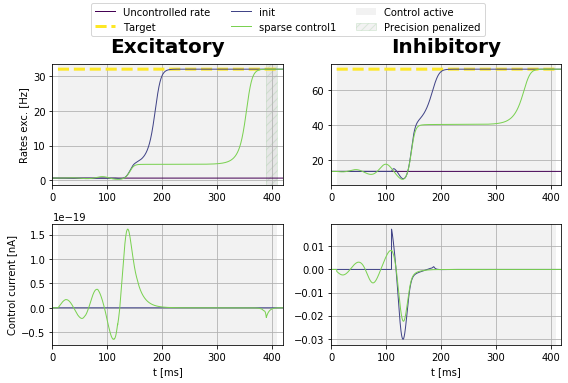

3


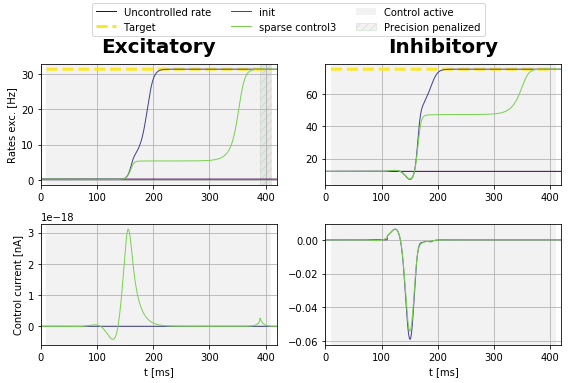

5


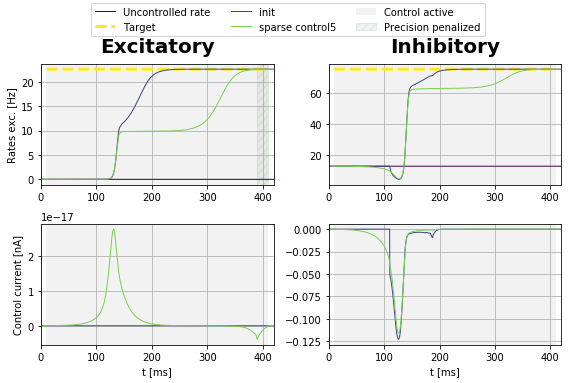

7


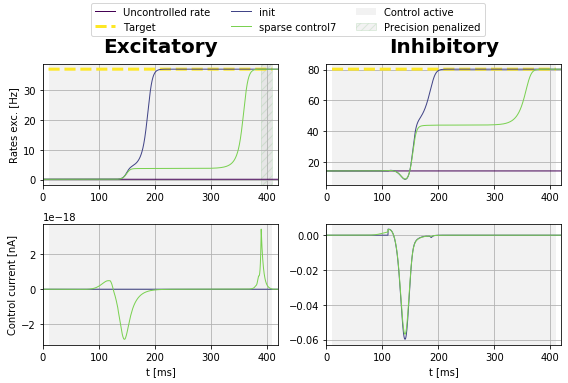

9


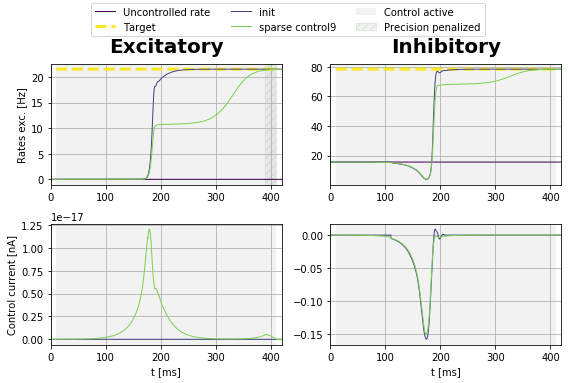

11


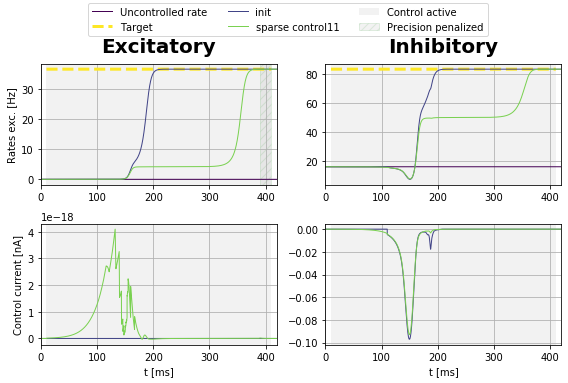

13


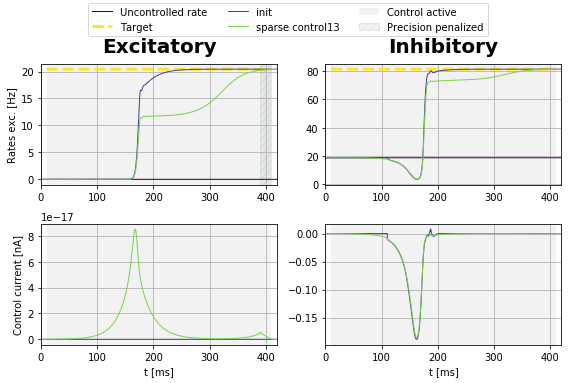

15


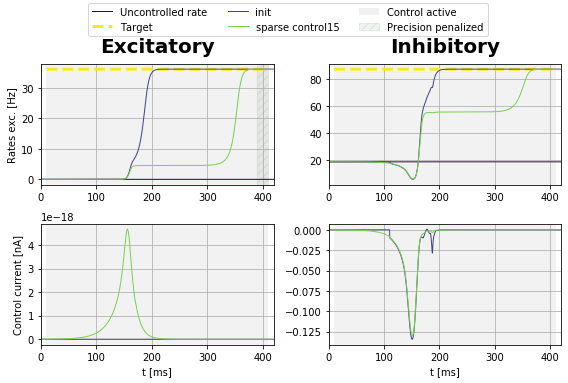

17


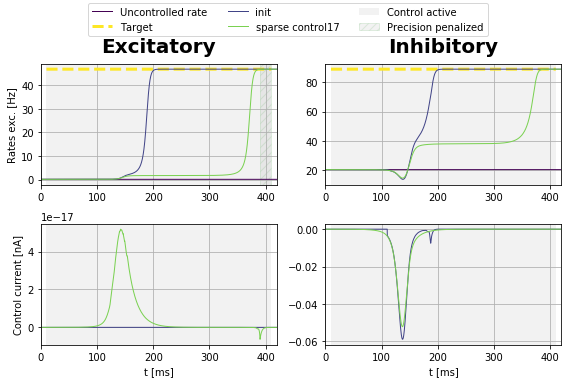

19


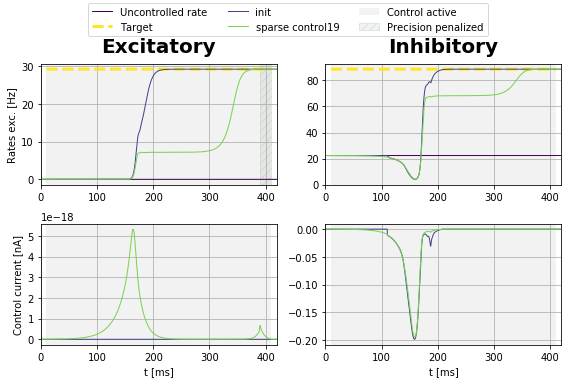

21


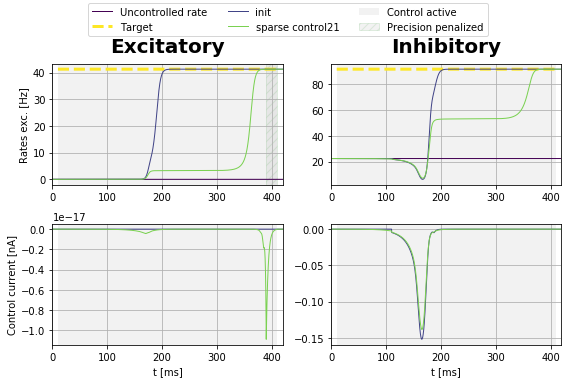

23


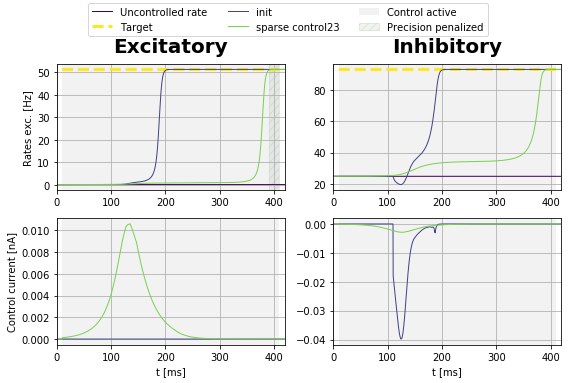

25


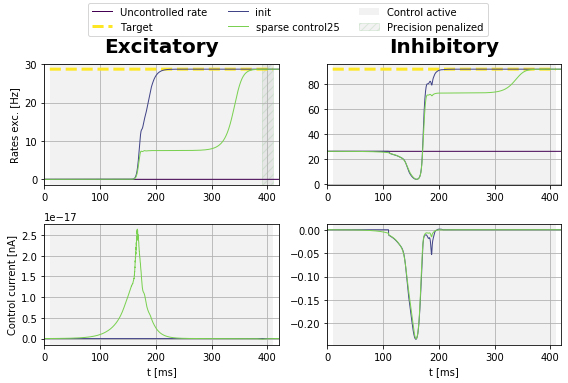

27


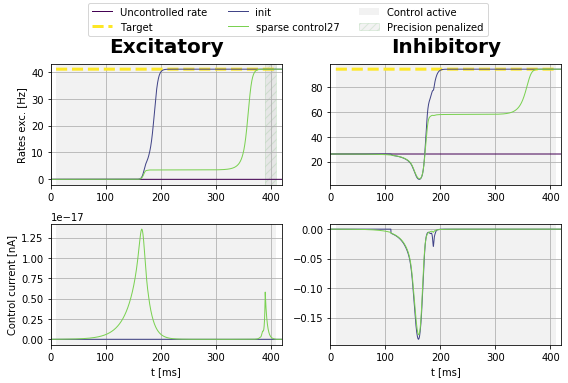

29


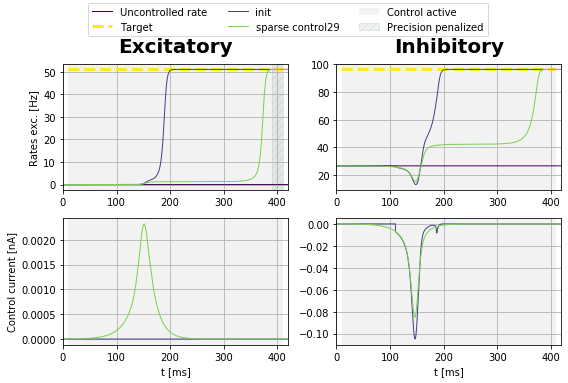

31


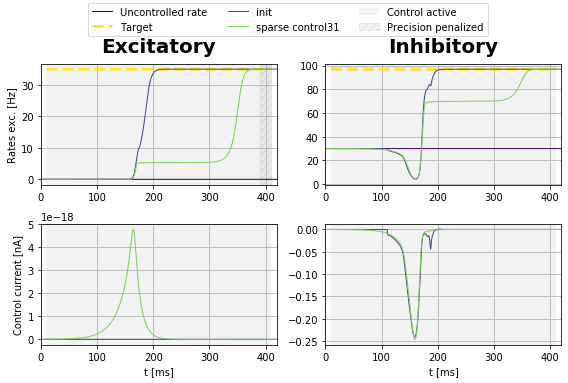

33


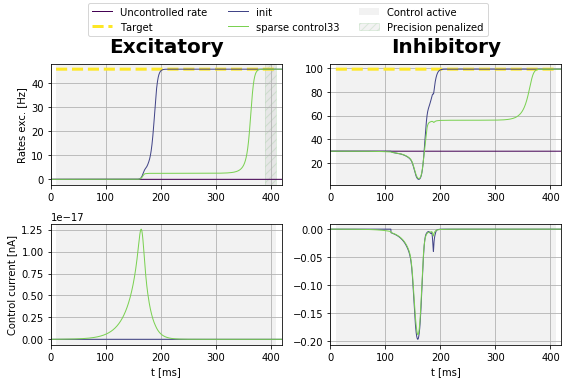

35


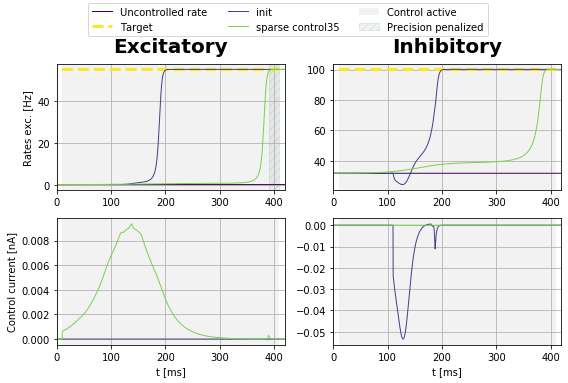

37


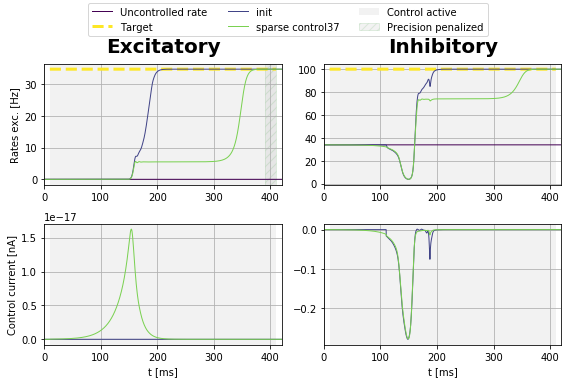

39


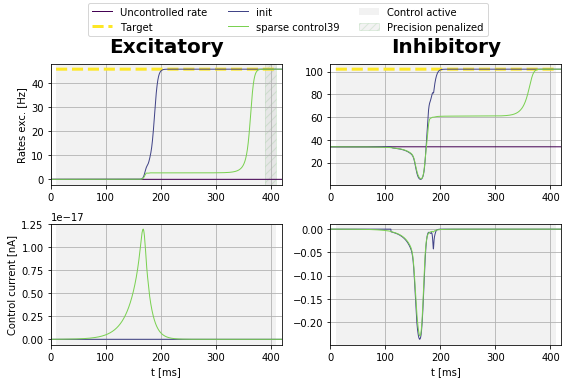

In [19]:
for i in i_range_0:
    print(i)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [15]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [16]:
factor_iteration = 0.1
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    """
    print(conv_1[start_index:limit:i_stepsize])
    full_converge = True
    
    for conv in conv_1[start_index:limit:i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
    """

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.9372884407405883
Gradient descend method:  None
RUN  1 , total integrated cost =  0.9372470362731259
RUN  2 , total integrated cost =  0.9372470068231902
RUN  3 , total integrated cost =  0.9372470068176261
RUN  4 , total integrated cost =  0.9372470068176239
RUN  5 , total integrated cost =  0.9372470068176223
RUN  6 , total integrated cost =  0.9372470068176222
step size too small
RUN  7 , total integrated cost =  0.9372470068176222
Control only changes marginally.
RUN  7 , total integrated cost =  0.9372470068176222
Improved over  7  iterations in  7.94195625197608  seconds by  0.004420616020112789  percent.
no convergence
-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.45196423606909475
Gradient descend method:

no convergence
-------  13 0.4000000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.999782098737667
Gradient descend method:  None
RUN  1 , total integrated cost =  3.9994805575203096
RUN  2 , total integrated cost =  3.9994799623270745
RUN  3 , total integrated cost =  3.99947996160733
RUN  4 , total integrated cost =  3.9994799616068115
RUN  5 , total integrated cost =  3.9994799616068093
RUN  6 , total integrated cost =  3.9994799616068084
step size too small
RUN  7 , total integrated cost =  3.9994799616068084
Control only changes marginally.
RUN  7 , total integrated cost =  3.9994799616068084
Improved over  7  iterations in  0.37318124203011394  seconds by  0.007553839769272486  percent.
no convergence
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.2294891559840755
Gradient descend method:  

RUN  2 , total integrated cost =  4.128333684307918
RUN  3 , total integrated cost =  4.1283336843079175
step size too small
RUN  4 , total integrated cost =  4.1283336843079175
Control only changes marginally.
RUN  4 , total integrated cost =  4.1283336843079175
Improved over  4  iterations in  0.2765980300027877  seconds by  1.4200609484760207e-05  percent.
no convergence
-------  27 0.47500000000000014 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.3898753585147023
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  3.3898753585147023
Control only changes marginally.
RUN  1 , total integrated cost =  3.3898753585147023
Improved over  1  iterations in  0.09709116001613438  seconds by  0.0  percent.
converged for  27
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.616731580

step size too small
RUN  3 , total integrated cost =  4.099864274847734
Control only changes marginally.
RUN  3 , total integrated cost =  4.099864274847734
Improved over  3  iterations in  0.22690125100780278  seconds by  3.182705981430445e-06  percent.
no convergence
-------  40 0.5250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.245070926724211
Gradient descend method:  None
RUN  1 , total integrated cost =  3.245070713338412
RUN  2 , total integrated cost =  3.2450707133214616
RUN  3 , total integrated cost =  3.245070713321454
RUN  4 , total integrated cost =  3.2450707133214536
RUN  5 , total integrated cost =  3.245070713321453
step size too small
RUN  6 , total integrated cost =  3.245070713321453
Control only changes marginally.
RUN  6 , total integrated cost =  3.245070713321453
Improved over  6  iterations in  0.3720923459623009  seconds by  6.576212427944483e-06  percent.
no convergenc

RUN  1 , total integrated cost =  6.390982958252137
RUN  2 , total integrated cost =  6.390982958252136
step size too small
RUN  3 , total integrated cost =  6.390982958252136
Control only changes marginally.
RUN  3 , total integrated cost =  6.390982958252136
Improved over  3  iterations in  0.2690048050135374  seconds by  6.42451362864449e-06  percent.
no convergence
-------  110 0.5000000000000002 0.8000000000000005
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10.326629828110567
Gradient descend method:  None
RUN  1 , total integrated cost =  10.32662975355747
RUN  2 , total integrated cost =  10.326629753556793
RUN  3 , total integrated cost =  10.326629753556787
step size too small
RUN  4 , total integrated cost =  10.326629753556787
Control only changes marginally.
RUN  4 , total integrated cost =  10.326629753556787
Improved over  4  iterations in  0.2737522120587528  seconds by  7.219565532068373e-07  percent.
no converge

step size too small
RUN  1 , total integrated cost =  1.6295104264662505
Control only changes marginally.
RUN  1 , total integrated cost =  1.6295104264662505
Improved over  1  iterations in  0.09320668992586434  seconds by  0.0  percent.
converged for  6
-------  7 0.4500000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.0356198307995779
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  1.0356198307995779
Control only changes marginally.
RUN  1 , total integrated cost =  1.0356198307995779
Improved over  1  iterations in  0.09271512704435736  seconds by  0.0  percent.
converged for  7
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.40615901880027805
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  0.40615901880027805
Control 

converged for  24
-------  25 0.4250000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.874510067276919
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  4.874510067276919
Control only changes marginally.
RUN  1 , total integrated cost =  4.874510067276919
Improved over  1  iterations in  0.16201028903014958  seconds by  0.0  percent.
converged for  25
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.1283336843079175
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  4.1283336843079175
Control only changes marginally.
RUN  1 , total integrated cost =  4.1283336843079175
Improved over  1  iterations in  0.09421345603186637  seconds by  0.0  percent.
converged for  26
-------  27 0.47500000000000014 0.5000000000000002
set cost params:

converged for  50
-------  55 0.4250000000000001 0.6250000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.699036830433451
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  8.699036830433451
Control only changes marginally.
RUN  1 , total integrated cost =  8.699036830433451
Improved over  1  iterations in  0.12981178401969373  seconds by  0.0  percent.
converged for  55
-------  60 0.5500000000000003 0.6250000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.260228248557672
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  4.260228248557672
Control only changes marginally.
RUN  1 , total integrated cost =  4.260228248557672
Improved over  1  iterations in  0.1174416330177337  seconds by  0.0  percent.
converged for  60
-------  65 0.5000000000000002 0.6500000000000004
set cost params:  1.0

converged for  140
-------  145 0.5750000000000002 0.9000000000000006
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.580582333709065
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  8.580582333709065
Control only changes marginally.
RUN  1 , total integrated cost =  8.580582333709065
Improved over  1  iterations in  0.10569588001817465  seconds by  0.0  percent.
converged for  145
--------------- 2
-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.9372470068176222
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  0.9372470068176222
Control only changes marginally.
RUN  1 , total integrated cost =  0.9372470068176222
Improved over  1  iterations in  0.11441345093771815  seconds by  0.0  percent.
converged for  0
-------  1 0.4250000000000001 0.3500000000000001

converged for  16
-------  17 0.5000000000000002 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.0285706211390664
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  1.0285706211390664
Control only changes marginally.
RUN  1 , total integrated cost =  1.0285706211390664
Improved over  1  iterations in  0.13902733195573092  seconds by  0.0  percent.
converged for  17
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.868652935124399
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  4.868652935124399
Control only changes marginally.
RUN  1 , total integrated cost =  4.868652935124399
Improved over  1  iterations in  0.10441393405199051  seconds by  0.0  percent.
converged for  18
-------  19 0.4250000000000001 0.4750000000000002
set cost params: 

converged for  35
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.455251142363483
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  6.455251142363483
Control only changes marginally.
RUN  1 , total integrated cost =  6.455251142363483
Improved over  1  iterations in  0.10512028797529638  seconds by  0.0  percent.
converged for  36
-------  37 0.4500000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.662079692801652
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  5.662079692801652
Control only changes marginally.
RUN  1 , total integrated cost =  5.662079692801652
Improved over  1  iterations in  0.11287879408337176  seconds by  0.0  percent.
converged for  37
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1

converged for  105
-------  110 0.5000000000000002 0.8000000000000005
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10.326629753556787
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  10.326629753556787
Control only changes marginally.
RUN  1 , total integrated cost =  10.326629753556787
Improved over  1  iterations in  0.10271279991138726  seconds by  0.0  percent.
converged for  110
-------  115 0.4250000000000001 0.8250000000000005
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.343980482415851
Gradient descend method:  None
step size too small
RUN  1 , total integrated cost =  15.343980482415851
Control only changes marginally.
RUN  1 , total integrated cost =  15.343980482415851
Improved over  1  iterations in  0.10674789908807725  seconds by  0.0  percent.
converged for  115
-------  120 0.5500000000000003 0.8250000000000005
set cost

24


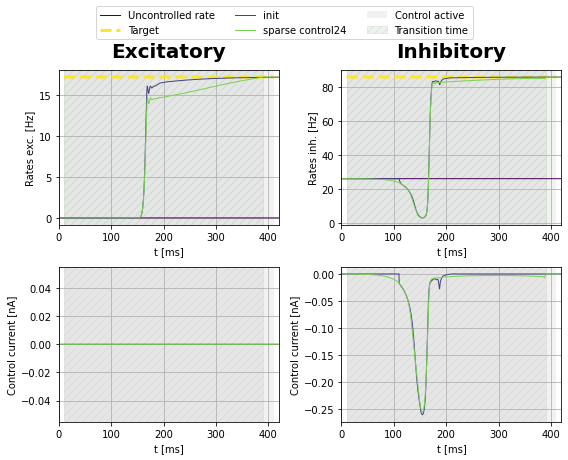

In [18]:
for i in i_range_1:
    print(i)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_1[i]],
        [costnode_init[i], costnode_1[i]], [weights_init[i], weights_1[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()